# Image augmentation with Albumentations

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import albumentations as alb

from utils import *

tf.config.experimental.set_visible_devices([], 'GPU') # force CPU usage
tf.version.VERSION

'2.5.0'

In [2]:
list_of_files = sorted(glob.glob('/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/*'))
list_of_files[:4], len(list_of_files)

(['/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/train-00000-of-01024',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/train-00001-of-01024',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/train-00002-of-01024',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/train-00003-of-01024'],
 1024)

In [3]:
image_shape = (224, 224)

def decode(serialized_example):
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    label = tf.cast(features['image/class/label'], tf.int64) - 1  # [0-999]
    return image, label

In [4]:
transforms = alb.Compose([
            alb.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30),
            alb.HorizontalFlip(p=0.5),
            alb.OneOf([ # Add or remove noise
                alb.GaussNoise(var_limit=(50, 200)),
                alb.ImageCompression(quality_lower=80, quality_upper=95),
                alb.GaussianBlur(sigma_limit=(2, 10)),
            ], p=1),
            alb.SomeOf([ # Color ops
                alb.ToGray(p=0.1),
                alb.Equalize(by_channels=False),
                alb.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
                alb.RandomGamma(gamma_limit=(90, 110)),
                alb.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10),
                alb.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.2, 0.2)),
            ], n=2),
            alb.RandomResizedCrop(*image_shape, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
            alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

def image_aug(img):
    aug_data = transforms(image=img)
    aug_img = aug_data["image"]
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=image_aug, inp=[image], Tout=tf.float32)
    return aug_img, label

<br>

Docs: https://albumentations.ai/

Demo: https://albumentations-demo.herokuapp.com/

<br>

In [5]:
AUTO = tf.data.experimental.AUTOTUNE

dataset = tf.data.TFRecordDataset(list_of_files)
dataset = dataset.map(decode, num_parallel_calls=AUTO)
dataset = dataset.map(process_data, num_parallel_calls=AUTO)
dataset = dataset.batch(6)

Image shape: (6, 224, 224, 3) Labels: [844 347 619 248 343  55]


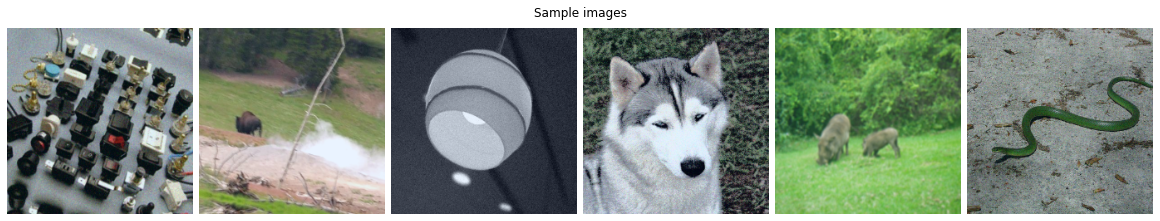

In [6]:
for images, labels in dataset.take(1):
    print('Image shape:', images.shape, 'Labels:', labels.numpy())

plot_grid(images.numpy(), 'Sample images', rows=1, figsize=(16, 3))
plt.show()

In [7]:
pd.DataFrame(images.numpy().ravel()).describe().T

,count,mean,std,min,25%,50%,75%,max
0,903168.0,0.036507,1.042642,-2.117904,-0.880697,0.091189,0.775076,2.64
